<a href="https://colab.research.google.com/github/adrinorosario/scratch-or-fineune/blob/main/flower102_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flowers102 Fine-Grain Recognition

In this project, we're going to perform image recognition and classification on the [Flower Datasets](https://www.robots.ox.ac.uk/~vgg/data/flowers/) from the [Visual Geometry Group, Oxford University](https://www.robots.ox.ac.uk/~vgg/). There are two distinct datasets that differ in the number of categories of flowers recorded in each of them:
* 17 category dataset
* 102 category dataset

We will try to build both a Convolutional Neural Network (or a ConvNet; CNN) and a Vision Transformer (ViT) and compare the performance of both the networks and try to determine which architecture might be more better than the other for fine-grain image recognition, especially on a small dataset.

We will first load all the necessary packages and libraries required for this project.

**Note:** The models built in this project will be tested on Apple's gpu's using metal performance shader. You can learn more about it [here](https://developer.apple.com/metal/pytorch/) or read the documentation from PyTorch [here](https://pytorch.org/docs/stable/mps.html).

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import pathlib
from pathlib import Path
import os
import PIL.Image

import random

In [ ]:
print(f"MPS backend is built: {torch.backends.mps.is_built()}")
print(f"MPS is available for us: {torch.backends.mps.is_available()}")

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

MPS backend is built: True
MPS is available for us: True
Using device: mps


## 1. Access, organize and prepare data

Now, we are going to access the dataset, namely the `102 Category Flower Dataset`; or`flower102`, we can call it that. The dataset is contained in `/102jpg` where each image is a part of the larger dataset. The labels are contained in [imagelabels.mat]("/Users/adrinorosario/Desktop/flowers102/102jpg/imagelabels.mat") and the splits for training are located in [setid.mat]("/Users/adrinorosario/Desktop/flowers102/102jpg/setid.mat"), both of which are matlab files.

This is what we are going to do:

1. First, we are going to get a list of all the images files in `102jpg` and sort them in ascending order so that we get them in a sorted list.
2. The [imagelabels.mat]("/Users/adrinorosario/Desktop/flowers102/102jpg/imagelabels.mat") file contains the label for all the images in sorted fashion.
    > Suppose we have **image_00025.jpg** being read in. Then, the 23rd item in the `imagelabels.mat` will have the corresponding label for the image mentioned.
    
    Therefore, after we read in each image, we are also going to read in the corresponding label and assign a label to said image.


In [ ]:
import scipy.io # to read the matlab file
label_mat = scipy.io.loadmat("./102jpg/imagelabels.mat")

In [ ]:
label_mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
 '__version__': '1.0',
 '__globals__': [],
 'labels': array([[77, 77, 77, ..., 62, 62, 62]], shape=(1, 8189), dtype=uint8)}

The `'labels'` item contains the array holding the image labels.

In [ ]:
image_files = sorted([files for files in os.listdir("102jpg") if files.endswith(".jpg")])
image_files

['image_00001.jpg',
 'image_00002.jpg',
 'image_00003.jpg',
 'image_00004.jpg',
 'image_00005.jpg',
 'image_00006.jpg',
 'image_00007.jpg',
 'image_00008.jpg',
 'image_00009.jpg',
 'image_00010.jpg',
 'image_00011.jpg',
 'image_00012.jpg',
 'image_00013.jpg',
 'image_00014.jpg',
 'image_00015.jpg',
 'image_00016.jpg',
 'image_00017.jpg',
 'image_00018.jpg',
 'image_00019.jpg',
 'image_00020.jpg',
 'image_00021.jpg',
 'image_00022.jpg',
 'image_00023.jpg',
 'image_00024.jpg',
 'image_00025.jpg',
 'image_00026.jpg',
 'image_00027.jpg',
 'image_00028.jpg',
 'image_00029.jpg',
 'image_00030.jpg',
 'image_00031.jpg',
 'image_00032.jpg',
 'image_00033.jpg',
 'image_00034.jpg',
 'image_00035.jpg',
 'image_00036.jpg',
 'image_00037.jpg',
 'image_00038.jpg',
 'image_00039.jpg',
 'image_00040.jpg',
 'image_00041.jpg',
 'image_00042.jpg',
 'image_00043.jpg',
 'image_00044.jpg',
 'image_00045.jpg',
 'image_00046.jpg',
 'image_00047.jpg',
 'image_00048.jpg',
 'image_00049.jpg',
 'image_00050.jpg',


Perfect, now we have read in the matlab file with the image labels as well as all the image file names.

In [ ]:
label_mat["labels"]

array([[77, 77, 77, ..., 62, 62, 62]], shape=(1, 8189), dtype=uint8)

In [ ]:
len(image_files) == label_mat["labels"].shape[1]

True

Now we have the same number of images as the number of labels.

In [ ]:
torch.unique(torch.tensor(label_mat["labels"][0]))

tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102], dtype=torch.uint8)

These are all the unique class names that we have which are correspond exactly to 102 number of labels for the dataset.

In [ ]:
image_labels = list(label_mat["labels"][0])
int(image_labels[0])

77

### 1.1 Create custom dataset

Now, we are going to create a custom dataset. In order to be efficient and mimic the functionality of a `torchvision` dataset, we will create a custom class to mimic the same functionality.

In [ ]:
from typing import Tuple, List, Dict

In [ ]:
torch.unique(torch.tensor([int(x) for x in image_labels]))

tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102])

We will create a class now that will take in the target directory containing all the images and the labels array holding the labels for each image as its initial arguments. It will then match the corresponding image to its label and return a tuple where the image is a tensor (`torch.tensor`) and the label is an `int`; returned as a `tuple`.

In [ ]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, directory: str, labels: np.array, transforms: bool):
        self.paths = sorted(list(pathlib.Path(directory).glob("*.jpg"))) # gets the path of all jpg images in the directory
        self.transforms = transforms
        self.labels = labels # the labels array provided to us where each label at a particular index corresponds to an image at that order in the sorted folder names
        self.classes = torch.unique(torch.tensor([int(x) for x in image_labels])) # all the unique class names in the dataset

    def load_image(self, index: int) -> PIL.Image.Image:
        image_path = self.paths[index] # gets the particular image at the specified index
        return PIL.Image.open(image_path)

    # overriding the __len__() method
    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        image = self.load_image(index=index)
        class_name = int(self.labels[index])

        if self.transforms:

            # to_tensor = transforms.ToTensor()
            # image_tensor = to_tensor(image)

            # mean = torch.mean(image_tensor, dim=(1, 2))
            # std = torch.std(image_tensor, dim=(1, 2))

            data_transforms = transforms.Compose([
                transforms.Resize(size=(299, 299)), # resizing images to 256x256
                transforms.CenterCrop(size=(224, 224)), #new
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5), #new
                transforms.ColorJitter(brightness=0.5, hue=0.2), #new
                transforms.RandomPosterize(bits=2),
                transforms.ToTensor()
                # transforms.Normalize(mean=mean, std=std)
            ])


            return data_transforms(image), class_name
        else:
            return image, class_name


In [ ]:
list(pathlib.Path("102jpg").glob("*.jpg"))

[PosixPath('102jpg/image_07088.jpg'),
 PosixPath('102jpg/image_06396.jpg'),
 PosixPath('102jpg/image_05847.jpg'),
 PosixPath('102jpg/image_04581.jpg'),
 PosixPath('102jpg/image_03588.jpg'),
 PosixPath('102jpg/image_02696.jpg'),
 PosixPath('102jpg/image_07936.jpg'),
 PosixPath('102jpg/image_00081.jpg'),
 PosixPath('102jpg/image_07922.jpg'),
 PosixPath('102jpg/image_00095.jpg'),
 PosixPath('102jpg/image_02682.jpg'),
 PosixPath('102jpg/image_05853.jpg'),
 PosixPath('102jpg/image_04595.jpg'),
 PosixPath('102jpg/image_06382.jpg'),
 PosixPath('102jpg/image_00903.jpg'),
 PosixPath('102jpg/image_02872.jpg'),
 PosixPath('102jpg/image_02866.jpg'),
 PosixPath('102jpg/image_00917.jpg'),
 PosixPath('102jpg/image_05884.jpg'),
 PosixPath('102jpg/image_04542.jpg'),
 PosixPath('102jpg/image_02133.jpg'),
 PosixPath('102jpg/image_06355.jpg'),
 PosixPath('102jpg/image_00724.jpg'),
 PosixPath('102jpg/image_00042.jpg'),
 PosixPath('102jpg/image_06433.jpg'),
 PosixPath('102jpg/image_02655.jpg'),
 PosixPath('

We will specify some transformations for our images in order to increase diversity. Now, we have to keep in mind that our dataset is relatively smaller; much smaller than one would deep sufficient to train a cnn. Therefore, we need to add sufficient number of data transformations to our images.

**Note**: The transformations added marked `#new` have not been added when `models/model_1_flower_102_experiment_1.pt` trained on the dataset.

In [ ]:
data_102 = CustomImageDataset(directory="102jpg",
                              labels=image_labels,
                              transforms=True)

data_102

### 1.2 Inspect dataset

In [ ]:
len(data_102) == len(image_labels) == len(image_files)

True

Same as the number of images and class labels.

In [ ]:
data_102.classes

tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102])

/var/folders/z1/cd374qgx421_hlkd_bg_nxtr0000gn/T/ipykernel_5106/2246118830.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  plt.imshow(image.T)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

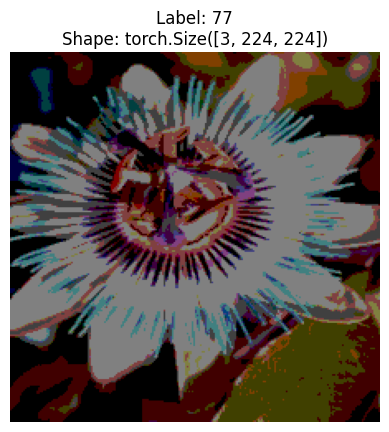

In [ ]:
image, label = data_102[0]

plt.imshow(image.T)
plt.title(f"Label: {label}\nShape: {image.shape}")
plt.axis(False)

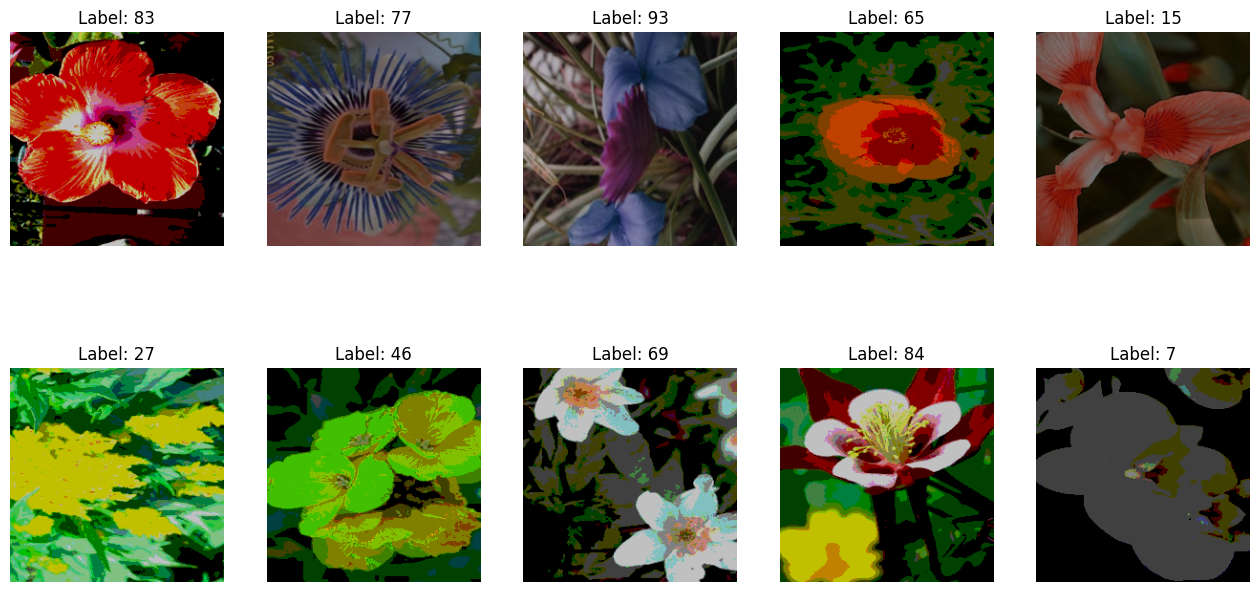

In [ ]:
random_samples = random.sample(range(len(data_102)), k=10)
random_samples

plt.figure(figsize=(16, 8))

for i, sample in enumerate(random_samples):
    image, label = data_102[sample]

    plt.subplot(2, 5, i+1)
    plt.imshow(image.T)
    plt.title(f"Label: {label}")
    plt.axis(False)

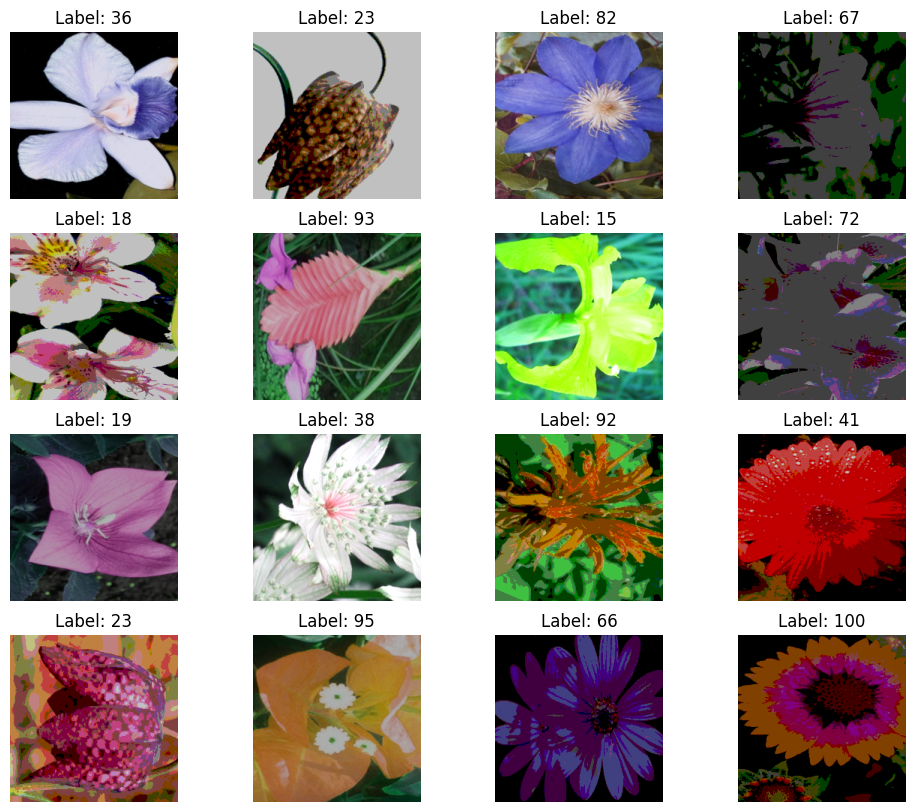

In [ ]:
torch.manual_seed(42)

nrows = 4
ncols = 4

random_samples = random.sample(range(len(data_102)), k=nrows*ncols)

plt.figure(figsize=(12, 10))

for i, sample in enumerate(random_samples):
    image, label = data_102[sample]

    plt.subplot(nrows, ncols, i+1)

    plt.imshow(image.T)
    plt.title(f"Label: {label}")
    plt.axis(False)

Great! We now have a good dataset and we can also see from the above visualizations that the data transformations of our `data_transforms` has been applied to some of the images.

### 1.3 Prepare train, test and validation sets

Now we have one single dataset where we have all the images as `Tuple[torch.tensor, int]`. However, it has not been split into train, test and validation sets. We will now aim to do that.

In [ ]:
set_ids = scipy.io.loadmat("./102jpg/setid.mat")
set_ids

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009',
 '__version__': '1.0',
 '__globals__': [],
 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]],
       shape=(1, 1020), dtype=uint16),
 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]],
       shape=(1, 1020), dtype=uint16),
 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]],
       shape=(1, 6149), dtype=uint16)}

In [ ]:
train_set_ids = set_ids["trnid"][0]
train_set_ids = [int(x) for x in train_set_ids]

test_set_ids = set_ids["tstid"][0]
test_set_ids = [int(x) for x in test_set_ids]

val_set_ids = set_ids["valid"][0]
val_set_ids = [int(x) for x in val_set_ids]

len(train_set_ids) +  len(test_set_ids) + len(val_set_ids)

8189

We now have the ids of the train, test and validation images in 3 different lists. We will now use them to split `data_102` into test, train and validation sets.

In [ ]:
train_images, train_labels = [], []

for items in train_set_ids:
    image, label = data_102[items]
    train_images.append(image)
    train_labels.append(label)

len(train_images) == len(train_labels) == len(train_set_ids)

True

In [ ]:
test_images, test_labels = [], []

for items in test_set_ids:
    try:
        image, label = data_102[items]
        test_images.append(image)
        test_labels.append(label)
    except IndexError:
        continue

len(test_images) == len(test_labels) == len(test_set_ids)

False

In [ ]:
len(test_images), len(test_labels), len(test_set_ids)

(6148, 6148, 6149)

In [ ]:
val_images, val_labels = [], []

for items in val_set_ids:
    image, label = data_102[items]
    val_images.append(image)
    val_labels.append(label)

len(val_images) == len(val_labels) == len(val_set_ids)

True

Now, we will create a class to create a custom datasets by passing in the images and the labels.

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images: list[torch.Tensor], labels: list[int]):
        self.images = images
        self.labels = labels

    def __len__(self):
        if len(self.images) == len(self.labels):
            return len(self.images)
        else:
            raise ValueError("Lengths of image and label list are not equal")

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

train_dataset = CustomDataset(images=test_images,
                              labels=test_labels)

test_dataset = CustomDataset(images=train_images,
                             labels=train_labels)

validation_dataset = CustomDataset(images=val_images,
                                   labels=val_labels)



**NOTE**: If you observe, the testing set is far more larger than the training set which is not ideal. Therefore, we are going to **_swap_** them for better model performance where the model has more data to train on and learn.

In [ ]:
train_dataset = CustomDataset(images=test_images,
                              labels=test_labels)

type(train_dataset), len(train_dataset)

(__main__.CustomDataset, 6148)

In [ ]:
test_dataset = CustomDataset(images=train_images,
                             labels=train_labels)

type(test_dataset), len(test_dataset)

(__main__.CustomDataset, 1020)

In [ ]:
validation_dataset = CustomDataset(images=val_images,
                                   labels=val_labels)

type(validation_dataset), len(validation_dataset)

(__main__.CustomDataset, 1020)

We now have 3 different datasets for training, testing and validation. Good!

## 2. Create and prepare DataLoader

We are now going to create dataloaders using PyTorch's `DataLoader` class which will turn our datasets into python iterables.

In [ ]:
from torchvision.transforms import v2
from torch.utils.data import default_collate

In [ ]:
cutmix = v2.CutMix(num_classes=len(data_102.classes))
mixup = v2.MixUp(num_classes=len(data_102.classes))
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              pin_memory=True,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             pin_memory=True,
                             shuffle=False)

validation_dataloader = DataLoader(dataset=validation_dataset,
                                   batch_size=BATCH_SIZE,
                                   num_workers=2,
                                   pin_memory=True,
                                   shuffle=False)

train_dataloader, test_dataloader, validation_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1590a27a0>,
 <torch.utils.data.dataloader.DataLoader at 0x159073c50>)

### 2.1 Inspect the dataloaders

In [ ]:
print(f"Length of train_dataloader: {len(train_dataloader)} with {BATCH_SIZE} batches")
print(f"Length of test_dataloader: {len(test_dataloader)} with {BATCH_SIZE} batches")
print(f"Length of validation_dataloader: {len(validation_dataloader)} with {BATCH_SIZE} batches")

Length of train_dataloader: 193 with 32 batches
Length of test_dataloader: 32 with 32 batches
Length of validation_dataloader: 32 with 32 batches


In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch, train_labels_batch

(tensor([[[[0.4902, 0.4078, 0.4039,  ..., 0.1020, 0.0980, 0.0863],
           [0.4275, 0.3804, 0.4353,  ..., 0.1098, 0.0980, 0.0941],
           [0.4431, 0.4196, 0.4863,  ..., 0.1216, 0.1137, 0.1098],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 0.1098, 0.0941, 0.0941],
           [1.0000, 1.0000, 1.0000,  ..., 0.0863, 0.0941, 0.1020],
           [1.0000, 1.0000, 1.0000,  ..., 0.0863, 0.0980, 0.1020]],
 
          [[0.4275, 0.3412, 0.3373,  ..., 0.1294, 0.1255, 0.1137],
           [0.3608, 0.3137, 0.3686,  ..., 0.1373, 0.1255, 0.1137],
           [0.3765, 0.3529, 0.4196,  ..., 0.1490, 0.1412, 0.1373],
           ...,
           [0.9490, 0.9529, 0.9216,  ..., 0.1216, 0.1020, 0.1098],
           [0.9647, 0.9490, 0.9098,  ..., 0.0980, 0.1020, 0.1137],
           [1.0000, 0.9961, 0.9529,  ..., 0.0941, 0.1020, 0.1137]],
 
          [[0.4196, 0.3373, 0.3294,  ..., 0.1098, 0.1020, 0.0941],
           [0.3529, 0.3098, 0.3647,  ..., 0.1137, 0.1020, 0.0980],
           [0.3686, 0.34

In [ ]:
len(train_features_batch), len(train_labels_batch)

(32, 32)

In [ ]:
train_labels_batch.shape, train_features_batch.shape

(torch.Size([32]), torch.Size([32, 3, 224, 224]))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

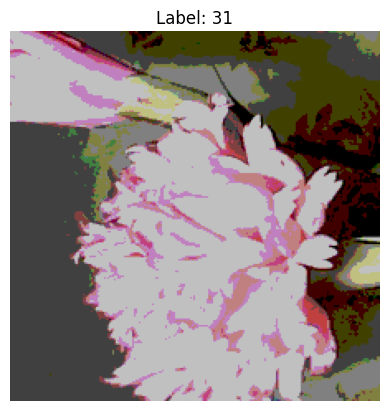

In [ ]:
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()

image, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(image.T)
plt.title(f"Label: {label}")
plt.axis(False)

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

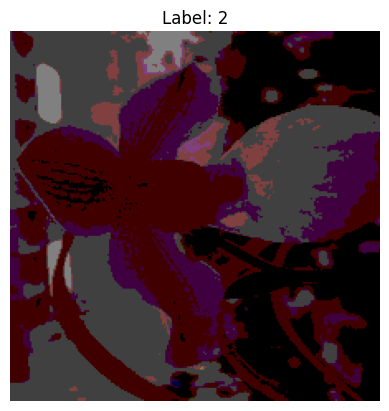

In [ ]:
test_features_batch, test_labels_batch = next(iter(test_dataloader))

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = test_features_batch[random_idx], test_labels_batch[random_idx]

plt.imshow(image.T)
plt.title(f"Label: {label}")
plt.axis(False)

Our `train_dataloader` and `test_dataloader` look to be working properly. We can now begin to build our model.

## 3. Building a baseline CNN

We will build a baseline CNN model and record its metrics. Then, we will further try other architectures and compare their metrics.

In [ ]:
from torch import nn

In [ ]:
class Flower102v1(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                    out_channels=64,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.adaptive_pooling = nn.AdaptiveAvgPool2d(output_size=(4,4))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=128*16,
                      out_features=len(data_102.classes))
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.adaptive_pooling(x)
        x = self.classifier(x)
        return x

In [ ]:
model_0 = Flower102v1(input_shape=3,
                      output_shape=len(data_102.classes)).to(device=device)

model_0

Flower102v1(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (adaptive_pooling): Adaptiv

### 3.1 Loss function, Optimizer and Learning Rate Scheduler

Now, coming to the optimizer. For this model, we will use the SGD optimizer. Here, we will also use a learning rate scheduler to help us tune or adjust the learning rate after each epoch for faster and better convergence.

In [ ]:
loss_0 = nn.CrossEntropyLoss()
optimizer_0 = torch.optim.SGD(params=model_0.parameters(),
                                lr=0.1,
                                momentum=0.9,
                                weight_decay=0.0001)

### Create training and testing functions

A lot of time can be saved and code redundancy avoided if we can code a train and test function for our models to use. Since the process will always be the same, we can create train and test functions which follow the same steps.

First, we will create a training function `model_train()` that takes in the model, the train dataloader, device (for device-agnostic code), loss function, optimizer. We will also pass in an accuracy function that we will create below. Also, we will be giving an option to use a learning rate scheduler. So the function will look something like:

```
model_train(model: nn.Module, dataloader: torch.utils.data.DataLoader, device: torch.device, loss_fn: nn.Module, optimizer_fn: torch.optim, lr_scheduler: bool = False, accuracy_fn)
```

In [ ]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (correct / len(y_pred)) * 100
    return accuracy

In [ ]:
from torch import nn

We will modify our training and testing functions to return the training and testing loss values so that we can plot them. They will return a dictionary which contains the number epochs, the training losses and the testing losses

In [ ]:
def model_train(model: nn.Module,
                dataloader: torch.utils.data.DataLoader,
                device: torch.device,
                loss_fn: nn.Module,
                optimizer_fn: torch.optim,
                num_epochs: int,
                lr_scheduler: bool = False,
                accuracy_fn=accuracy_fn) -> tuple:
    model.to(device=device)
    model.train()

    train_loss, train_acc = 0, 0 # these variables will accumulate the loss and accuracy scores for each iteration

    # iterate over the batch, (image, label) in the dataloader
    for batch, (X_feature, y_label) in enumerate(dataloader):
        # send the features and labels to the target device
        X_feature, y_label = X_feature.to(device), y_label.to(device)
        X_feature, y_label = cutmix_or_mixup(X_feature, y_label)

        y_predictions = model(X_feature) # send the features to the forward pass

        # calculate loss and accuracy and add them to the train_loss and train_acc
        loss = loss_fn(y_predictions, y_label)
        acc = accuracy_fn(y_predictions.argmax(dim=1),
                          y_label)

        train_loss += loss

        train_acc += acc

        optimizer_fn.zero_grad() # set the gradients to zero
        loss.backward() # perform backpropagation
        optimizer_fn.step() # step the optimizer

        if not lr_scheduler:
            continue
        else:
            # torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_fn, mode="min", factor=0.1, patience=5).step(metrics=loss)
            torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer_fn, T_max=len(dataloader) * num_epochs)

    # divide both the variables with accumulated values by total length to get the final result value
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    print(f"Training loss: {train_loss: .4f} | Training acc: {train_acc: .2f}%")

    return (train_loss, train_acc)

Now, we will create a function to replicate the testing loop for evaluation our model. The function `model_test()` will take the model, dataloader with the training samples, the loss function, accuracy function as well as the device. It will be as follows:

```
model_test(model: nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: nn.Module,  accuracy_fn, device: torch.device)
```

In [ ]:
def model_test(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               device: torch.device,
               accuracy_fn=accuracy_fn,) -> tuple:

    test_loss, test_acc = 0, 0 # these variables will accumulate the loss and accuracy for each iteration over the iterables in the dataloader

    model.to(device=device) # put the model on target device
    model.eval() # set the model to eval mode for testing

    with torch.inference_mode():
        for X_features, y_label in dataloader:
            X_features, y_label = X_features.to(device), y_label.to(device)

            test_prediction = model(X_features)

            loss = loss_fn(test_prediction, y_label)

            acc = accuracy_fn(y_pred=test_prediction.argmax(dim=1),
                              y_true=y_label)

            test_loss += loss
            test_acc += acc

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

        print(f"Test loss: {test_loss: .4f} | Test acc: {test_acc: .2f}%")

    return (test_loss, test_acc)

In [ ]:
next(model_0.parameters()).device, device

NameError: name 'model_0' is not defined

Let us also create a function that will return the total time taken for the model to perform the training loop as a dictionary

In [ ]:
def print_train_time(model: nn.Module,
                     start_time: float,
                     end_time: float,
                     device: torch.device):
    time_taken = end_time - start_time
    train_time = dict({
        "model": model._get_name(),
        "device": device,
        "train_time": time_taken
    })
    return train_time

### 3.3 Train and test model_0

We are now ready to train our baseline model on the training set. We will use the standard training loop structure to train our model using `model_train()` and `model_test()`.

In [ ]:
from tqdm.auto import tqdm
import time

In [ ]:
epochs = 10
start_train_time_model_0_on_mps = time.time()

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}...")

    model_train(model=model_0,
                dataloader=train_dataloader,
                device=device,
                loss_fn=loss_0,
                optimizer_fn=optimizer_0,
                lr_scheduler=True,
                accuracy_fn=accuracy_fn)

    model_test(model=model_0,
               dataloader=test_dataloader,
               loss_fn=loss_0,
               device=device,
               accuracy_fn=accuracy_fn)

stop_train_time_model_0_on_mps = time.time()

model_0_train_time_on_mps = print_train_time(model=model_0,
                                             start_time=start_train_time_model_0_on_mps,
                                             end_time=stop_train_time_model_0_on_mps,
                                             device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0...
Training loss:  3.9439 | Training acc:  11.32%
Test loss:  3.8109 | Test acc:  9.96%
Epoch: 1...
Training loss:  3.2226 | Training acc:  19.74%
Test loss:  3.3035 | Test acc:  18.55%
Epoch: 2...
Training loss:  2.9286 | Training acc:  27.01%
Test loss:  3.2717 | Test acc:  18.08%
Epoch: 3...
Training loss:  2.7009 | Training acc:  31.20%
Test loss:  3.1589 | Test acc:  21.29%
Epoch: 4...
Training loss:  2.5629 | Training acc:  34.78%
Test loss:  2.9843 | Test acc:  27.11%
Epoch: 5...
Training loss:  2.4120 | Training acc:  37.45%
Test loss:  3.0795 | Test acc:  24.92%
Epoch: 6...
Training loss:  2.2571 | Training acc:  40.59%
Test loss:  2.8580 | Test acc:  28.66%
Epoch: 7...
Training loss:  2.1202 | Training acc:  44.03%
Test loss:  5.9392 | Test acc:  14.19%
Epoch: 8...
Training loss:  2.0822 | Training acc:  45.66%
Test loss:  2.9233 | Test acc:  29.24%
Epoch: 9...
Training loss:  1.9191 | Training acc:  47.83%
Test loss:  2.9043 | Test acc:  29.91%


The model has shown signs of learning well but would need a lot more epochs and training time to get to a good training and testing accuracy; get a less loss value.

We will move forward and build a deeper CNN and try to train it on our data.

In [ ]:
128*16

2048

In [ ]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME_0 = "model_0_flower102_baseline.pt"
MODEL_SAVE_PATH_0 = MODEL_PATH / MODEL_NAME_0

print(f"Saving to {MODEL_SAVE_PATH_0}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH_0)

Saving to models/model_0_flower102_baseline.pt


In [ ]:
torch.save(train_dataloader, "flower102_train_dataloader.pt")
torch.save(test_dataloader, "flower102_test_dataloader.pt")
torch.save(validation_dataloader, "flower102_validation_dataloader.pt")

## 4. Building a deeper CNN

Our model has performed well, compared to the number of epochs and progression in the training accuracy. However, the testing accuracy has not progressed and is well below what we can expect even from an average performing model. Therefore, we will now try to build a deeper model with more progressive filters.

In [ ]:
class Flower102v2(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2,
            #              stride=2)
        )

        self.shortcut1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=128, kernel_size=1, stride=2),
            nn.BatchNorm2d(num_features=128)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.relu = nn.ReLU(inplace=True)

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            # nn.ReLU(),
            # # nn.Dropout(p=0.5),
            # nn.MaxPool2d(kernel_size=2,
            #              stride=2)
        )

        self.shortcut2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=2),
            nn.BatchNorm2d(num_features=256)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            # nn.ReLU(),
            # # nn.Dropout(p=0.2),
            # nn.MaxPool2d(kernel_size=2,
            #              stride=2)
        )

        self.shortcut3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=2),
            nn.BatchNorm2d(num_features=512)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.adaptive_pooling = nn.AdaptiveAvgPool2d(output_size=(4,4))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # nn.Dropout(p=0.2),
            # nn.Linear(in_features=512,
            #           out_features=256,),
            # nn.BatchNorm1d(num_features=256),
            # nn.ReLU(),

            nn.Dropout(p=0.2),
            nn.Linear(in_features=512*16,
                      out_features=102)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # block 1
        identity_1 = x
        out1 = self.conv_block1(x)
        out1 = self.pool1(out1)
        out1 = out1 + self.shortcut1(identity_1)
        out1 = self.relu(out1)

        # block 2
        identity_2 = out1
        out2 = self.conv_block2(out1)
        out2 = self.pool2(out2)
        out2 = out2 + self.shortcut2(identity_2)
        out2 = self.relu(out2)

        # block 3
        identity_3 = out2
        out3 = self.conv_block3(out2)
        out3 = self.pool3(out3)
        out3 = out3 + self.shortcut3(identity_3)
        out3 = self.relu(out3)

        # classifier
        x = self.adaptive_pooling(out3)
        x = self.classifier(x)
        return x

In [ ]:
model_1 = Flower102v2(input_shape=3,
                      output_shape=102)

model_1

Flower102v2(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (conv_block2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256,

In [ ]:
loss_1 = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_1 = torch.optim.AdamW(params=model_1.parameters(),
                                lr=0.001,
                                weight_decay=0.01)

In [ ]:
train_dataloader = torch.load("flower102_train_dataloader.pt", weights_only=False)
test_dataloader = torch.load("flower102_test_dataloader.pt", weights_only=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1385cdfd0>,
 <torch.utils.data.dataloader.DataLoader at 0x138597d90>)

In [ ]:
import time
from tqdm.auto import tqdm

In [ ]:
epochs = 10
start_train_time_model_1_on_mps = time.time()

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}...")

    model_train(model=model_1,
                dataloader=train_dataloader,
                device=device,
                loss_fn=loss_1,
                optimizer_fn=optimizer_1,
                lr_scheduler=True,
                num_epochs=epochs,
                accuracy_fn=accuracy_fn)

    model_test(model=model_1,
               dataloader=test_dataloader,
               loss_fn=loss_1,
               device=device,
               accuracy_fn=accuracy_fn)

stop_train_time_model_1_on_mps = time.time()

model_1_train_time_on_mps = print_train_time(model=model_1,
                                             start_time=start_train_time_model_1_on_mps,
                                             end_time=stop_train_time_model_1_on_mps,
                                             device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0...


RuntimeError: MPS backend out of memory (MPS allocated: 15.55 GB, other allocations: 1.00 GB, max allowed: 18.13 GB). Tried to allocate 2.00 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
512*16

8192

In [ ]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME_1 = "model_1_flower102_experiment_1.pt"
MODEL_SAVE_PATH_1 = MODEL_PATH / MODEL_NAME_1

print(f"Saving to {MODEL_SAVE_PATH_1}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH_1)

Saving to models/model_1_flower102_experiment_1.pt


`model_1_flower102_experiment_1.pt` contains the model weights for **model_1** without skip connections where the metrics after training for 10 epochs with a batch size of 32 were as follows:

```
Training loss:  1.6029 | Training acc:  55.47%
Test loss:  2.0767 | Test acc:  44.14%
```

In [ ]:
len(train_dataloader), len(test_dataloader)

(49, 8)

## 5. Building a model after some research

We have tried a lot of different techniques on our own and have failed to achieve a model that can fit well to the data and achieve higher accuracy and a lower loss and converge well. Therefore, after some research, we are going to build a model by starting small and gradually scaling up.

We are going to consider the following while building the CNN model architecture:
- The input size/shape
- The number of filters per layer (width of the model)
- The number of layers (depth of the model)
- The strides of the architecture
- Whether you are constructing it as blocks (like VGG) or only layers. Contributes to the complexity of the architecture.
- Employing regularization techniques (such as dropout and batch norm)

In [ ]:
def plot_loss_curves(epochs: int, train_losses: list, test_losses: list):
    epochs = np.arange(1, epochs+1)

    plt.plot(epochs, train_losses, label="Training loss")
    plt.plot(epochs, test_losses, label="Testing loss")

    plt.title("Training and testing loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.legend(loc="best")
    plt.show()

def plot_accuracy_curves(epochs: int, train_accuracies: list, test_accuracies: list):
    epochs = np.arange(1, epochs+1)

    plt.plot(epochs, train_accuracies, label="Training loss")
    plt.plot(epochs, test_accuracies, label="Testing loss")

    plt.title("Training and testing accuracies")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.legend(loc="best")
    plt.show()

In [ ]:
import torch.nn.init as init
from torch.nn.utils import spectral_norm

In [ ]:
def model_train(model: nn.Module,
                dataloader: torch.utils.data.DataLoader,
                device: torch.device,
                loss_fn: nn.Module,
                optimizer_fn: torch.optim,
                use_lr_scheduler: bool = False,
                lr_scheduler: torch.optim = None,
                accuracy_fn=accuracy_fn) -> tuple:
    model.to(device=device)
    model.train()

    train_loss, train_acc = 0, 0 # these variables will accumulate the loss and accuracy scores for each iteration

    # iterate over the batch, (image, label) in the dataloader
    for batch, (X_feature, y_label) in enumerate(dataloader):
        # send the features and labels to the target device
        X_feature, y_label = X_feature.to(device), y_label.to(device)

        y_predictions = model(X_feature) # send the features to the forward pass

        # calculate loss and accuracy and add them to the train_loss and train_acc
        loss = loss_fn(y_predictions, y_label)
        acc = accuracy_fn(y_predictions.argmax(dim=1),
                          y_label)

        train_loss += loss

        train_acc += acc

        optimizer_fn.zero_grad() # set the gradients to zero
        loss.backward() # perform backpropagation
        optimizer_fn.step() # step the optimizer

        if use_lr_scheduler and lr_scheduler is not None and isinstance(lr_scheduler, torch.optim.lr_scheduler.CosineAnnealingLR):
            # torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_fn, mode="min", factor=0.1, patience=5).step(metrics=loss)
            lr_scheduler.step()

    # divide both the variables with accumulated values by total length to get the final result value
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    print(f"Training loss: {train_loss: .4f} | Training acc: {train_acc: .2f}%")

    if use_lr_scheduler and lr_scheduler is not None:
         # Get the last learning rate from the optimizer's param groups
         current_lr = optimizer_fn.param_groups[0]['lr']
         print(f"Current LR: {current_lr:.6f}")

    return (train_loss, train_acc)

In [ ]:
from torchvision.ops import DropBlock2d

In [ ]:
class EfficientFlowerNet(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels=input_shape, out_channels=64, kernel_size=5, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(num_features=64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(num_features=128)
        self.relu = nn.ReLU(inplace=False)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(num_features=256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.dropblock = DropBlock2d(block_size=5, p=0.1)

        self.conv_4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(num_features=512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.25),
            nn.Linear(in_features=512,
                      out_features=output_shape)
        )

        self.adaptive_pooling = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.batch_norm1(self.conv_1(x)))
        x = self.maxpool1(x)

        x = self.relu(self.batch_norm2(self.conv_2(x)))
        x = self.maxpool2(x)

        x = self.relu(self.batch_norm3(self.conv_3(x)))
        x = self.maxpool3(x)
        # x = self.dropblock(x)

        x = self.relu(self.batch_norm4(self.conv_4(x)))
        # x = self.spatial_dropout4(x)
        x = self.maxpool4(x)

        x = self.adaptive_pooling(x)


        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        print("Initializing weights")
        for m in self.modules():
            if isinstance(m, nn.Conv2d): # if it is an convolution layer, apply the Kaiming weights initialization
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

        print("Weight initialization finished")



In [ ]:
model_2 = EfficientFlowerNet(input_shape=3,
                             output_shape=len(data_102.classes))

model_2

Initializing weights
Weight initialization finished


EfficientFlowerNet(
  (conv_1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
loss_2 = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_2 = torch.optim.AdamW(params=model_2.parameters(),
                                lr=0.001,
                                weight_decay=0.05)

loss_2, optimizer_2

(CrossEntropyLoss(),
 AdamW (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0.05
 ))

In [ ]:
from tqdm.auto import tqdm

In [ ]:
epochs = 10

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer_2, T_max=epochs)

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}...")

    train_loss, train_acc = model_train(model=model_2,
                dataloader=train_dataloader,
                device=device,
                loss_fn=loss_2,
                optimizer_fn=optimizer_2,
                use_lr_scheduler=True,
                lr_scheduler=lr_scheduler,
                accuracy_fn=accuracy_fn)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_loss, test_acc = model_test(model=model_2,
               dataloader=test_dataloader,
               loss_fn=loss_2,
               device=device,
               accuracy_fn=accuracy_fn)

    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0...
Training loss:  4.1549 | Training acc:  8.79%
Current LR: 0.000206
Test loss:  4.2228 | Test acc:  4.88%
Epoch 1...
Training loss:  3.8580 | Training acc:  12.78%
Current LR: 0.000345
Test loss:  4.1899 | Test acc:  7.23%
Epoch 2...
Training loss:  3.7119 | Training acc:  15.30%
Current LR: 0.000976
Test loss:  3.8695 | Test acc:  10.55%
Epoch 3...
Training loss:  3.5968 | Training acc:  17.97%
Current LR: 0.000095
Test loss:  3.8778 | Test acc:  13.38%
Epoch 4...
Training loss:  3.4822 | Training acc:  21.05%
Current LR: 0.000500
Test loss:  3.8852 | Test acc:  12.70%
Epoch 5...
Training loss:  3.3997 | Training acc:  23.49%
Current LR: 0.000905
Test loss:  3.6712 | Test acc:  16.11%
Epoch 6...
Training loss:  3.2983 | Training acc:  25.32%
Current LR: 0.000024
Test loss:  3.5677 | Test acc:  16.52%
Epoch 7...
Training loss:  3.2127 | Training acc:  29.02%
Current LR: 0.000655
Test loss:  4.4637 | Test acc:  9.57%
Epoch 8...
Training loss:  3.1275 | Training acc:  31.06%
Cu

In [ ]:
train_losses = [x.cpu().detach().numpy() for x in train_losses]
test_losses = [x.cpu().detach().numpy() for x in test_losses]

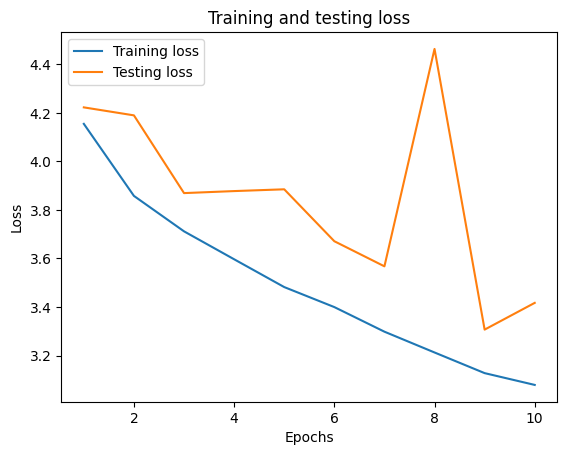

In [ ]:
plot_loss_curves(epochs=epochs, train_losses=train_losses, test_losses=test_losses)

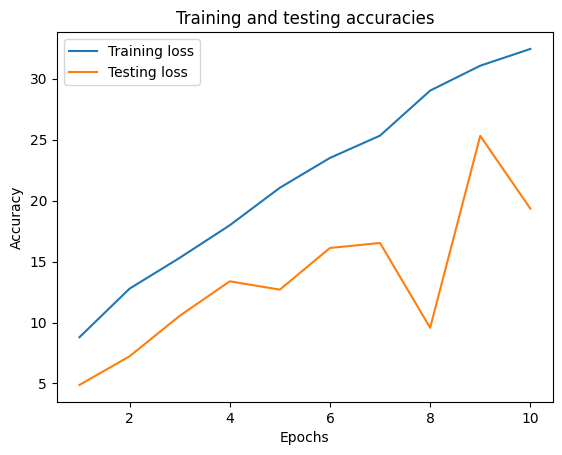

In [ ]:
plot_accuracy_curves(epochs=epochs, train_accuracies=train_accuracies, test_accuracies=test_accuracies)

In [ ]:
from torchsummary import summary
summary(model=model_2.to("cpu"), input_size=image.shape, batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 224, 224]           1,792
       BatchNorm2d-2         [32, 64, 224, 224]             128
              ReLU-3         [32, 64, 224, 224]               0
         MaxPool2d-4         [32, 64, 112, 112]               0
            Conv2d-5        [32, 128, 112, 112]          73,856
       BatchNorm2d-6        [32, 128, 112, 112]             256
              ReLU-7        [32, 128, 112, 112]               0
         MaxPool2d-8          [32, 128, 56, 56]               0
            Conv2d-9          [32, 128, 56, 56]         147,584
      BatchNorm2d-10          [32, 128, 56, 56]             256
             ReLU-11          [32, 128, 56, 56]               0
        MaxPool2d-12          [32, 128, 28, 28]               0
           Conv2d-13          [32, 128, 28, 28]         147,584
      BatchNorm2d-14          [32, 128,

In [ ]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 111, 111]           4,864
       BatchNorm2d-2         [32, 64, 111, 111]             128
              ReLU-3         [32, 64, 111, 111]               0
         MaxPool2d-4           [32, 64, 55, 55]               0
            Conv2d-5          [32, 128, 55, 55]          73,856
       BatchNorm2d-6          [32, 128, 55, 55]             256
              ReLU-7          [32, 128, 55, 55]               0
         MaxPool2d-8          [32, 128, 27, 27]               0
            Conv2d-9          [32, 128, 27, 27]         147,584
      BatchNorm2d-10          [32, 128, 27, 27]             256
             ReLU-11          [32, 128, 27, 27]               0
        MaxPool2d-12          [32, 128, 13, 13]               0
           Conv2d-13          [32, 256, 13, 13]         295,168
      BatchNorm2d-14          [32, 256,

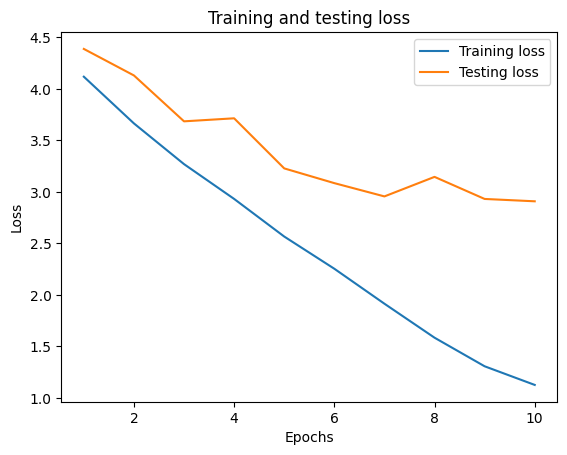

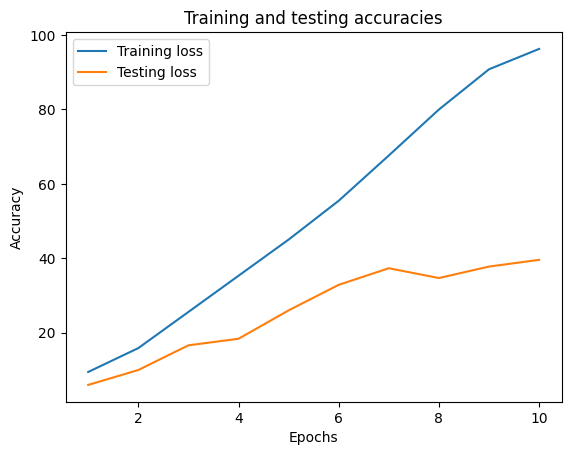

In [ ]:
exp_1_results = {
    "model_info": summary(model=model_2.to("cpu"), input_size=image.shape, batch_size=32),
    "loss_curve": plot_loss_curves(epochs=epochs, train_losses=train_losses, test_losses=test_losses),
    "accuracy_curve": plot_accuracy_curves(epochs=epochs, train_accuracies=train_accuracies, test_accuracies=test_accuracies)

}

Here, we are seeing that a model with more than 2 million parameters tends to overfit on the data though we have applied data augmentation. The model is only 6 layers deep but tends to overfit. Therefore, we will try other techniques and try to make it less complex.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 111, 111]           4,864
       BatchNorm2d-2         [32, 64, 111, 111]             128
              ReLU-3         [32, 64, 111, 111]               0
         MaxPool2d-4           [32, 64, 55, 55]               0
            Conv2d-5          [32, 128, 55, 55]          73,856
       BatchNorm2d-6          [32, 128, 55, 55]             256
              ReLU-7          [32, 128, 55, 55]               0
         MaxPool2d-8          [32, 128, 27, 27]               0
            Conv2d-9          [32, 256, 27, 27]         295,168
      BatchNorm2d-10          [32, 256, 27, 27]             512
             ReLU-11          [32, 256, 27, 27]               0
        MaxPool2d-12          [32, 256, 13, 13]               0
           Conv2d-13          [32, 512, 13, 13]       1,180,160
      BatchNorm2d-14          [32, 512,

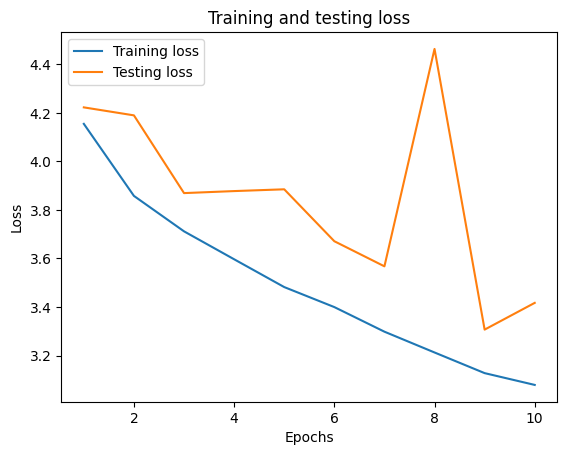

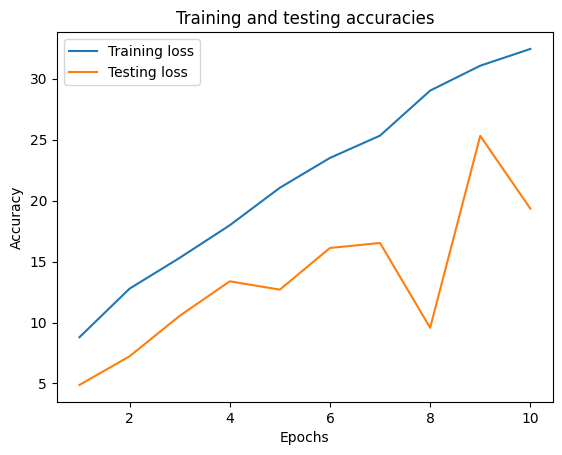

In [ ]:
exp_2_results = {
    "model_info": summary(model=model_2.to("cpu"), input_size=image.shape, batch_size=32),
    "loss_curve": plot_loss_curves(epochs=epochs, train_losses=train_losses, test_losses=test_losses),
    "accuracy_curve": plot_accuracy_curves(epochs=epochs, train_accuracies=train_accuracies, test_accuracies=test_accuracies)

}

## Utilizing Transfer Learning

We have tried much to build a custom model/architecture to fit well on the flower102 dataset but have not tasted success. Deeper models overfit and smaller models underfit. Therefore, we will utilise transfer learning as a means to enable better fitting on our dataset.

In [ ]:
from torchvision.models import squeezenet1_0, SqueezeNet1_0_Weights

squeezenet_weights = SqueezeNet1_0_Weights.DEFAULT
squeezenet_weights

auto_transforms = squeezenet_weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, directory: str, labels: np.array, transforms=None):
        self.paths = sorted(list(pathlib.Path(directory).glob("*.jpg"))) # gets the path of all jpg images in the directory
        self.transforms = transforms
        self.labels = labels # the labels array provided to us where each label at a particular index corresponds to an image at that order in the sorted folder names
        self.classes = torch.unique(torch.tensor([int(x) for x in image_labels])) # all the unique class names in the dataset

    def load_image(self, index: int) -> PIL.Image.Image:
        image_path = self.paths[index] # gets the particular image at the specified index
        return PIL.Image.open(image_path)

    # overriding the __len__() method
    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        image = self.load_image(index=index)
        class_name = int(self.labels[index])

        if self.transforms is not None:
            return transforms(image), class_name
        else:
            return image, class_name

data_102 = CustomImageDataset(directory="102jpg",
                              labels=image_labels,
                              transforms=GoogLeNet_Weights)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images: list[torch.Tensor], labels: list[int]):
        self.images = images
        self.labels = labels

    def __len__(self):
        if len(self.images) == len(self.labels):
            return len(self.images)
        else:
            raise ValueError("Lengths of image and label list are not equal")

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

train_dataset = CustomDataset(images=test_images,
                              labels=test_labels)

test_dataset = CustomDataset(images=train_images,
                             labels=train_labels)

validation_dataset = CustomDataset(images=val_images,
                                   labels=val_labels)

from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              pin_memory=True,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             pin_memory=True,
                             shuffle=False)

validation_dataloader = DataLoader(dataset=validation_dataset,
                                   batch_size=BATCH_SIZE,
                                   num_workers=2,
                                   pin_memory=True,
                                   shuffle=False)

train_dataloader, test_dataloader, validation_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x306bb9a50>,
 <torch.utils.data.dataloader.DataLoader at 0x306bb9c50>)

In [ ]:
model_3 = squeezenet1_0(weights=squeezenet_weights)
model_3

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [ ]:
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from torchinfo import summary as model_summary
summary(model=model_3, input_size=image.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 109, 109]          14,208
              ReLU-2         [-1, 96, 109, 109]               0
         MaxPool2d-3           [-1, 96, 54, 54]               0
            Conv2d-4           [-1, 16, 54, 54]           1,552
              ReLU-5           [-1, 16, 54, 54]               0
            Conv2d-6           [-1, 64, 54, 54]           1,088
              ReLU-7           [-1, 64, 54, 54]               0
            Conv2d-8           [-1, 64, 54, 54]           9,280
              ReLU-9           [-1, 64, 54, 54]               0
             Fire-10          [-1, 128, 54, 54]               0
           Conv2d-11           [-1, 16, 54, 54]           2,064
             ReLU-12           [-1, 16, 54, 54]               0
           Conv2d-13           [-1, 64, 54, 54]           1,088
             ReLU-14           [-1, 64,

In [ ]:
for params in model_3.features.parameters():
    params.requires_grad = False

In [ ]:
loss_3 = nn.CrossEntropyLoss()
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=0.001)

In [ ]:
epochs = 10

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer_3, T_max=epochs)

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}...")

    train_loss, train_acc = model_train(model=model_3,
                dataloader=train_dataloader,
                device=device,
                loss_fn=loss_3,
                optimizer_fn=optimizer_3,
                use_lr_scheduler=True,
                lr_scheduler=lr_scheduler,
                accuracy_fn=accuracy_fn)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_loss, test_acc = model_test(model=model_3,
               dataloader=test_dataloader,
               loss_fn=loss_3,
               device=device,
               accuracy_fn=accuracy_fn)

    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0...
Training loss:  4.8915 | Training acc:  9.39%
Current LR: 0.000206
Test loss:  4.0714 | Test acc:  12.42%
Epoch 1...
Training loss:  2.9365 | Training acc:  30.51%
Current LR: 0.000345
Test loss:  3.0493 | Test acc:  27.89%
Epoch 2...
Training loss:  2.2534 | Training acc:  44.82%
Current LR: 0.000976
Test loss:  2.5382 | Test acc:  37.99%
Epoch 3...
Training loss:  1.8451 | Training acc:  53.77%
Current LR: 0.000095
Test loss:  2.3544 | Test acc:  40.75%
Epoch 4...
Training loss:  1.6056 | Training acc:  60.07%
Current LR: 0.000500
Test loss:  2.1693 | Test acc:  46.68%
Epoch 5...
Training loss:  1.4096 | Training acc:  64.94%
Current LR: 0.000905
Test loss:  2.0041 | Test acc:  50.31%
Epoch 6...
Training loss:  1.2850 | Training acc:  67.94%
Current LR: 0.000024
Test loss:  1.8495 | Test acc:  53.26%
Epoch 7...
Training loss:  1.1553 | Training acc:  71.11%
Current LR: 0.000655
Test loss:  1.8110 | Test acc:  53.88%
Epoch 8...
Training loss:  1.0712 | Training acc:  72.99%

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 96, 109, 109]          14,208
              ReLU-2         [32, 96, 109, 109]               0
         MaxPool2d-3           [32, 96, 54, 54]               0
            Conv2d-4           [32, 16, 54, 54]           1,552
              ReLU-5           [32, 16, 54, 54]               0
            Conv2d-6           [32, 64, 54, 54]           1,088
              ReLU-7           [32, 64, 54, 54]               0
            Conv2d-8           [32, 64, 54, 54]           9,280
              ReLU-9           [32, 64, 54, 54]               0
             Fire-10          [32, 128, 54, 54]               0
           Conv2d-11           [32, 16, 54, 54]           2,064
             ReLU-12           [32, 16, 54, 54]               0
           Conv2d-13           [32, 64, 54, 54]           1,088
             ReLU-14           [32, 64,

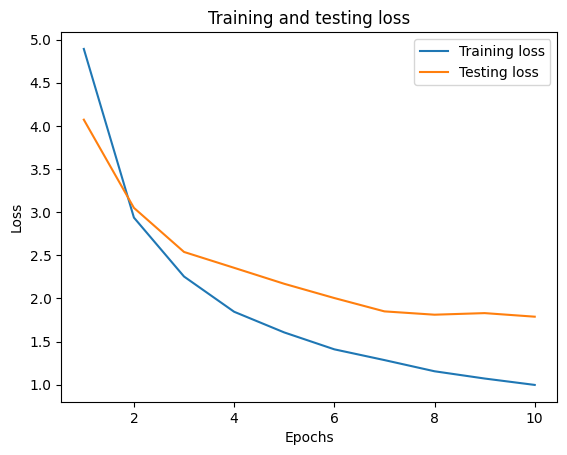

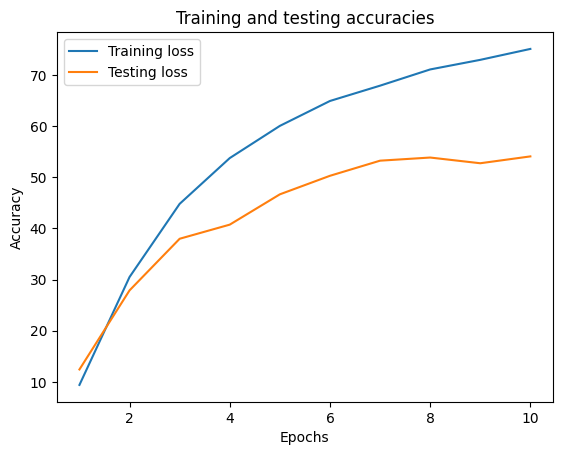

In [ ]:
train_losses = [x.cpu().detach().numpy() for x in train_losses]
test_losses = [x.cpu().detach().numpy() for x in test_losses]

squeezenet1_0_exp_results = {
    "model_info": summary(model=model_3.to("cpu"), input_size=image.shape, batch_size=32),
    "loss_curve": plot_loss_curves(epochs=epochs, train_losses=train_losses, test_losses=test_losses),
    "accuracy_curve": plot_accuracy_curves(epochs=epochs, train_accuracies=train_accuracies, test_accuracies=test_accuracies)
}

In [ ]:
from torchvision.models import googlenet, GoogLeNet_Weights

gnet_weights = GoogLeNet_Weights.IMAGENET1K_V1
gnet_weights.transforms()

model_4 = googlenet(weights=gnet_weights)
model_4

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /Users/adrinorosario/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:08<00:00, 5.82MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
for param in model_4.parameters():
    param.requires_grad = False

In [ ]:
model_4.fc = nn.Sequential(
    nn.Linear(in_features=1024, out_features=102, bias=True)
)

In [ ]:
loss_4 = nn.CrossEntropyLoss()
optimizer_4 = torch.optim.Adam(model_4.parameters(), lr=0.001)

In [ ]:
epochs = 10

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer_4, T_max=epochs)

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}...")

    train_loss, train_acc = model_train(model=model_4,
                dataloader=train_dataloader,
                device=device,
                loss_fn=loss_4,
                optimizer_fn=optimizer_4,
                use_lr_scheduler=True,
                lr_scheduler=lr_scheduler,
                accuracy_fn=accuracy_fn)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_loss, test_acc = model_test(model=model_4,
               dataloader=test_dataloader,
               loss_fn=loss_4,
               device=device,
               accuracy_fn=accuracy_fn)

    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0...
Training loss:  3.8334 | Training acc:  18.75%
Current LR: 0.000206
Test loss:  3.5968 | Test acc:  19.92%
Epoch 1...
Training loss:  2.7535 | Training acc:  44.14%
Current LR: 0.000345
Test loss:  2.8220 | Test acc:  37.99%
Epoch 2...
Training loss:  2.1513 | Training acc:  57.24%
Current LR: 0.000976
Test loss:  2.3594 | Test acc:  47.13%
Epoch 3...
Training loss:  1.7646 | Training acc:  65.09%
Current LR: 0.000095
Test loss:  2.0441 | Test acc:  55.76%
Epoch 4...
Training loss:  1.5054 | Training acc:  70.45%
Current LR: 0.000500
Test loss:  1.8334 | Test acc:  58.11%
Epoch 5...
Training loss:  1.3321 | Training acc:  72.86%
Current LR: 0.000905
Test loss:  1.6586 | Test acc:  60.48%
Epoch 6...
Training loss:  1.1913 | Training acc:  75.86%
Current LR: 0.000024
Test loss:  1.5830 | Test acc:  62.43%
Epoch 7...
Training loss:  1.0981 | Training acc:  77.38%
Current LR: 0.000655
Test loss:  1.4874 | Test acc:  63.49%
Epoch 8...
Training loss:  1.0075 | Training acc:  78.93

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
       BasicConv2d-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]           4,096
       BatchNorm2d-6           [32, 64, 56, 56]             128
       BasicConv2d-7           [32, 64, 56, 56]               0
            Conv2d-8          [32, 192, 56, 56]         110,592
       BatchNorm2d-9          [32, 192, 56, 56]             384
      BasicConv2d-10          [32, 192, 56, 56]               0
        MaxPool2d-11          [32, 192, 28, 28]               0
           Conv2d-12           [32, 64, 28, 28]          12,288
      BatchNorm2d-13           [32, 64, 28, 28]             128
      BasicConv2d-14           [32, 64,

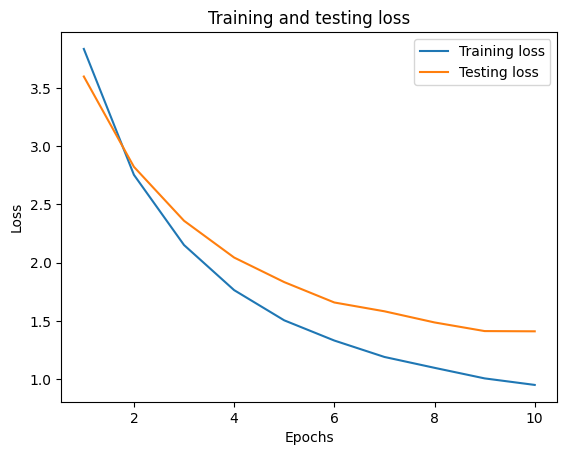

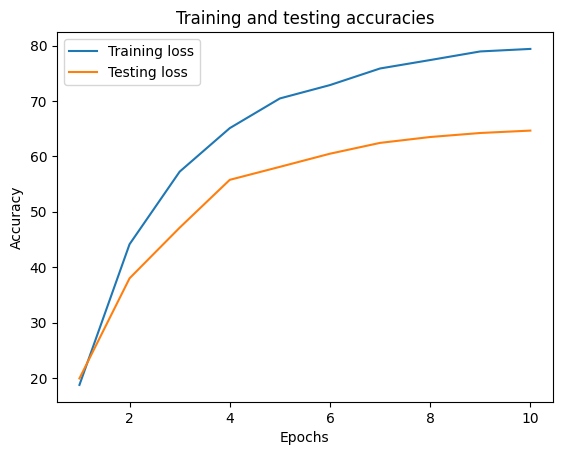

In [ ]:
train_losses = [x.cpu().detach().numpy() for x in train_losses]
test_losses = [x.cpu().detach().numpy() for x in test_losses]

gnet_exp_results = {
    "model_info": summary(model=model_4.to("cpu"), input_size=image.shape, batch_size=32),
    "loss_curve": plot_loss_curves(epochs=epochs, train_losses=train_losses, test_losses=test_losses),
    "accuracy_curve": plot_accuracy_curves(epochs=epochs, train_accuracies=train_accuracies, test_accuracies=test_accuracies)
}

In [ ]:
torch.save(train_dataloader, "augmented_flower102_train_dataloader.pt")
torch.save(test_dataloader, "augmented_flower102_test_dataloader.pt")
torch.save(validation_dataloader, "augmented_flower102_validation_dataloader.pt")

In [ ]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME_3 = "model_3_flower102.pt"
MODEL_NAME_4 = "model_4_flower102.pt"
MODEL_SAVE_PATH_3 = MODEL_PATH / MODEL_NAME_3
MODEL_SAVE_PATH_4 = MODEL_PATH / MODEL_NAME_4

print(f"Saving to {MODEL_SAVE_PATH_3}")
torch.save(obj=model_3.state_dict(), f=MODEL_SAVE_PATH_3)
print(f"Saving to {MODEL_SAVE_PATH_4}")
torch.save(obj=model_4.state_dict(), f=MODEL_SAVE_PATH_4)

Saving to models/model_3_flower102.pt
Saving to models/model_4_flower102.pt
